### Intro to Language Modeling

- First we will train a statistical bigram character level language model using bag-of-words approach.
- Then we will try to reach to same level of performance using gradient based neural network approach
- Both will have same number of parameters and reach similar performance but using completely different approach

This sets us up for understanding the basics of language modeling. Going forward, to make the models better, we can scale the neural network approach by using more complex neural nets and varying architectures.

In this notebook,
- we use a basic fully connected neural network which takes in a character and outputs a probability distribution
- we use the distribution to sample the next character and the cycle repeat untils the model outputs the end character.
- The model is made up of single fully connected layer consisting of 27 neurons, one for each input character

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import torch

In [122]:
# list of names

url = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
r = requests.get(url).text
words = r.splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

### Statistical approach

In [123]:
# get the bigrams from the corpus

bigrams = []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigrams.append(f"{ch1}{ch2}")

In [124]:
# maintain counts of bigrams in a map

bigrams_count = {}
for bigram in bigrams:
    if bigram not in bigrams_count:
        bigrams_count[bigram] = 0
    bigrams_count[bigram] += 1

In [125]:
# character to index
stoi = {}
for i, ch in enumerate('.abcdefghijklmnopqrstuvwxyz'):
    stoi[ch] = i

# index to character
itos = []
for i in range(26):
    itos.append(chr(ord('a') + i))
itos = ['.'] + itos

In [126]:
# create a matrix of counts for bigrams

counts_table = torch.zeros((27, 27), dtype=torch.int32)
for bigram, count in bigrams_count.items():
    ch1, ch2 = bigram
    idx1 = stoi[ch1]
    idx2 = stoi[ch2]
    counts_table[idx1, idx2] = count
    counts_table[idx2, idx1] = count

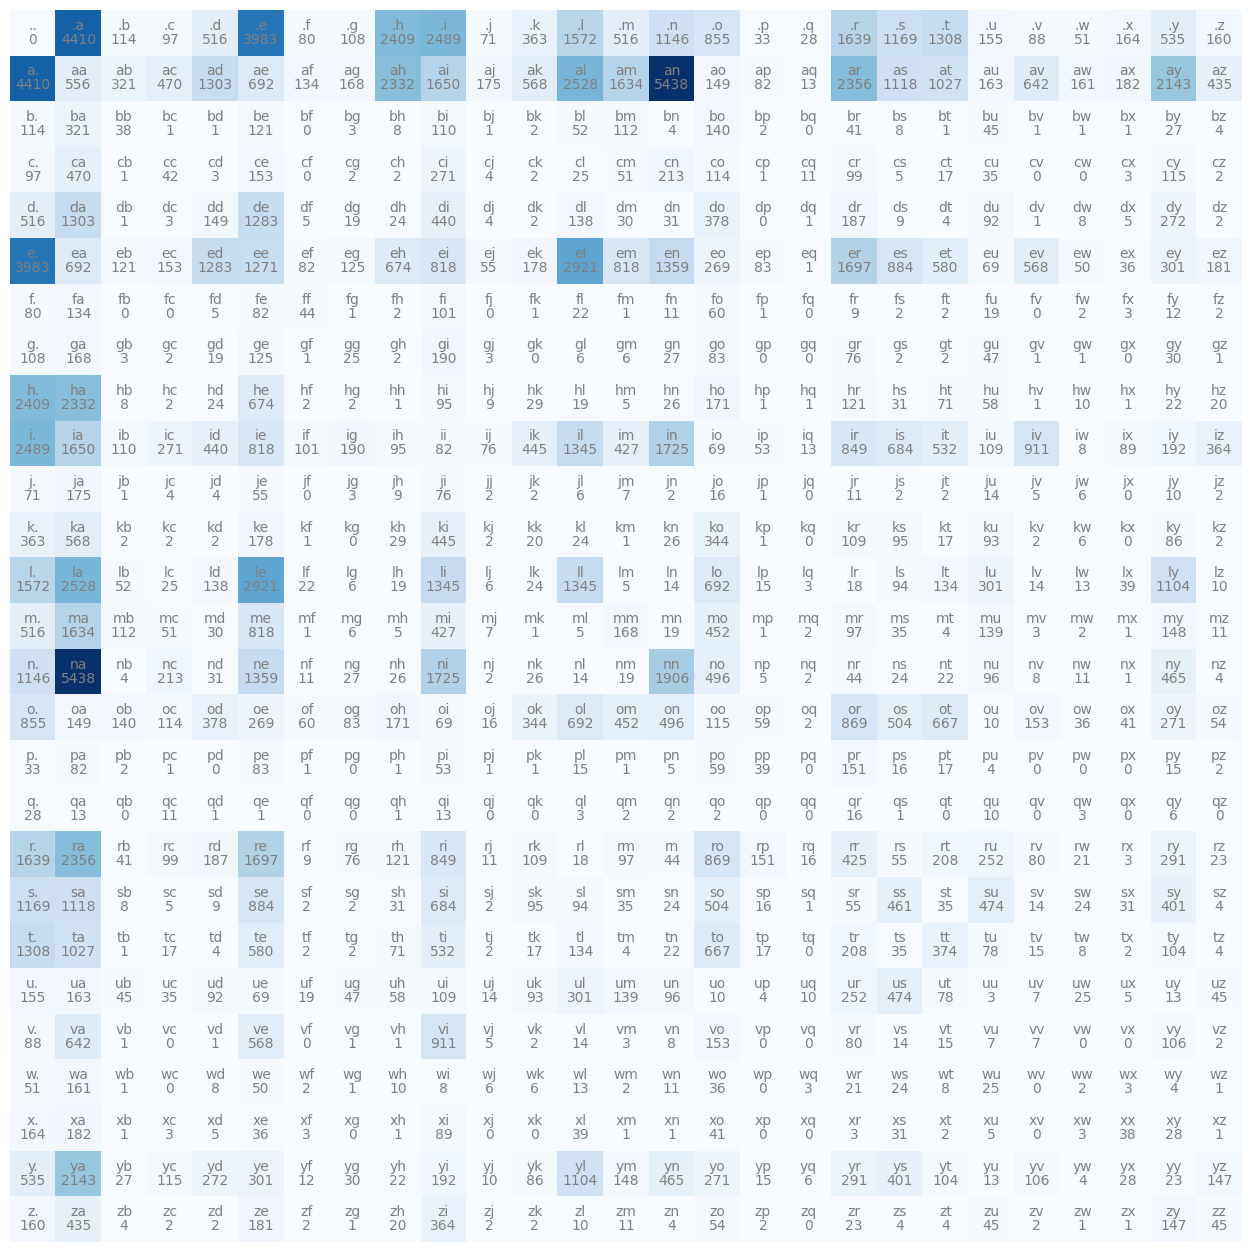

In [127]:
# display the matrix

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 16))
plt.imshow(counts_table, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, counts_table[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [128]:
# calculate the probabilities from the counts matrix

probs = counts_table / counts_table.sum(1, keepdim=True)

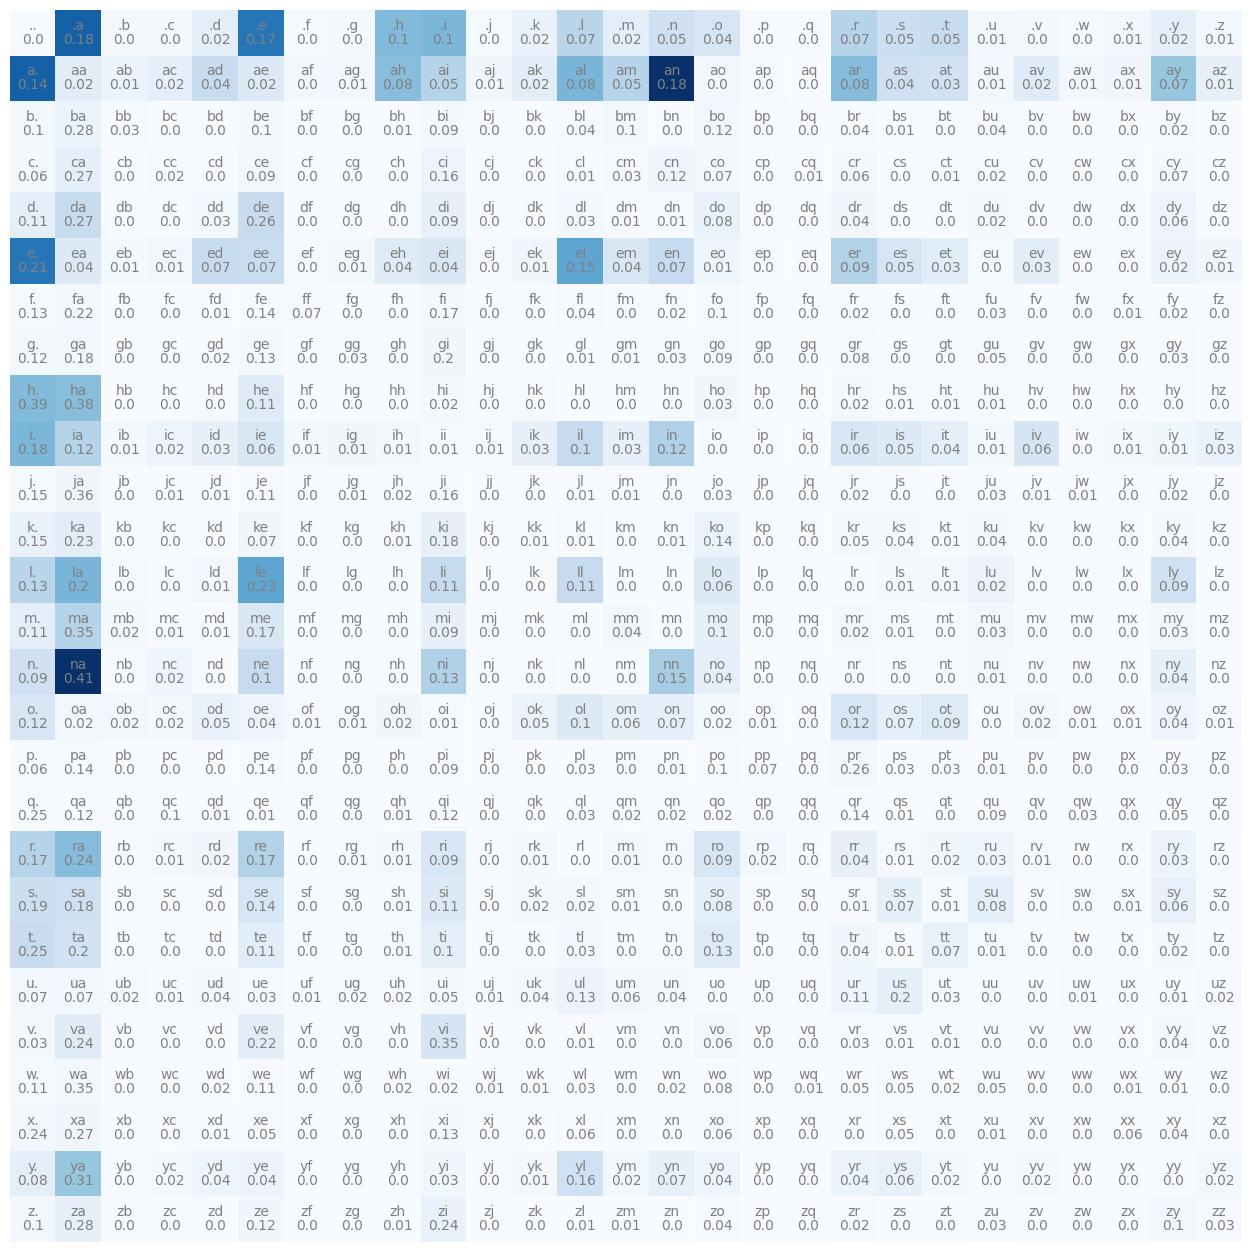

In [129]:
# display the probabilities

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 16))
plt.imshow(counts_table, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, round(probs[i, j].item(), 2), ha="center", va="top", color='gray')
plt.axis('off');

In [130]:
# sample from the trained statistical model

for i in range(10):
    idx = 0
    while True:
        distribution = probs[idx]
        next_idx = torch.multinomial(distribution, num_samples=1, replacement=True).item()
        print(itos[next_idx], end="")
        if next_idx == 0:
            break
        idx = next_idx
    print("")

asyayinn.
pcni.
h.
fayleeelh.
ei.
diliaccadid.
zani.
lys.
dalercn.
sadin.


#### evaluation of the model

- evaluation by calculating the likelihood
- calculate the log of likelihood for convinience (log(a*b) = log(a) + log(b))
- increasing log likelihood equivalent to decreasing the negative log likelihood
- equivalent to decreasing average negative log likelihood

In [131]:
# evaluation of the model

log_likelihood = 0.0
n = 0
for word in words[:5]:
    chs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        prob = probs[idx1, idx2]
        log_prob = prob.log().item()
        log_likelihood += log_prob
        n += 1
nll = -log_likelihood
anll = nll / n

print(f"{log_likelihood=:.2f}", end='\n\n')
print(f"{nll=:.2f}")
print(f"{anll=:.2f}")

log_likelihood=-82.42

nll=82.42
anll=2.58


Additional point on statistical approach: Smoothing

In [138]:
# if we perform evaluation on words which are not in training set and if any of the bigram has prob = 0.0, the loss will be infinite

# evaluation of the model

log_likelihood = 0.0
n = 0
for word in ["nitishqq"]:
    chs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        prob = probs[idx1, idx2]
        log_prob = prob.log().item()
        log_likelihood += log_prob
        n += 1
nll = -log_likelihood
anll = nll / n

print(f"{log_likelihood=:.2f}", end='\n\n')
print(f"{nll=:.2f}")
print(f"{anll=:.2f}")

log_likelihood=-inf

nll=inf
anll=inf


- To mitigate this, add 1 to all the counts in the `counts_table` matrix. This will make sure no probability is zero.
- This will smooth out the probability by a tiny amount. If you add more to the counts, the probabilities will even out further and the distribution will become more and more uniform.
- By controlling the amount you add, you can control how uniform distribution you want.

In [141]:
probs_smooth = (counts_table + 1) / (counts_table + 1).sum(1, keepdim=True)

log_likelihood = 0.0
n = 0
for word in ["nitishqq"]:
    chs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        prob = probs_smooth[idx1, idx2]
        log_prob = prob.log().item()
        log_likelihood += log_prob
        n += 1
nll = -log_likelihood
anll = nll / n

print(f"{log_likelihood=:.2f}", end='\n\n')
print(f"{nll=:.2f}")
print(f"{anll=:.2f}")

log_likelihood=-33.49

nll=33.49
anll=3.72


Now the loss is not infinite

#### Deep Learning Approach

In [15]:
# okay... so in the deep learning approach, how do we proceed?
# we want a neural network to output the probability distribution for the succeding character

# we will insert first characters of bigrams as input as a one hot vector and get the output probabilities
# we will sample from the output probabilities using the multinomial distribution
# calculate the anll loss (average negative log likelihood) using the second character of bigram as ground truth

# calculate the gradients
# update the weights
# run over a training loop

In [43]:
# create the training set

xs = []
ys = []
for bigram in bigrams:
    idx1 = stoi[bigram[0]]
    idx2 = stoi[bigram[1]]
    xs.append(idx1)
    ys.append(idx2)

In [104]:
# data preparation
xt = torch.tensor(xs)
yt = torch.tensor(ys)
x_one_hot = torch.nn.functional.one_hot(xt, num_classes=27).float()

# weights initialization
W = torch.randn((27, 27), requires_grad=True)

In [105]:
# training loop

loss_log = []
for i in range(100):

    # forward pass
    logits = x_one_hot @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(len(xs)), yt].log().mean()
    loss_log.append(loss.item())
    print(f"{loss=:.4f}")

    # backward pass
    W.grad = None
    loss.backward()

    # update
    W.data += -50 * W.grad

loss=3.7810
loss=3.3803
loss=3.1518
loss=3.0103
loss=2.9140
loss=2.8423
loss=2.7883
loss=2.7467
loss=2.7138
loss=2.6871
loss=2.6650
loss=2.6466
loss=2.6310
loss=2.6177
loss=2.6062
loss=2.5963
loss=2.5875
loss=2.5798
loss=2.5729
loss=2.5666
loss=2.5610
loss=2.5558
loss=2.5512
loss=2.5469
loss=2.5429
loss=2.5393
loss=2.5359
loss=2.5328
loss=2.5299
loss=2.5271
loss=2.5246
loss=2.5222
loss=2.5200
loss=2.5179
loss=2.5159
loss=2.5140
loss=2.5122
loss=2.5106
loss=2.5090
loss=2.5075
loss=2.5060
loss=2.5047
loss=2.5033
loss=2.5021
loss=2.5009
loss=2.4998
loss=2.4987
loss=2.4976
loss=2.4966
loss=2.4957
loss=2.4948
loss=2.4939
loss=2.4930
loss=2.4922
loss=2.4914
loss=2.4907
loss=2.4899
loss=2.4892
loss=2.4886
loss=2.4879
loss=2.4873
loss=2.4867
loss=2.4861
loss=2.4855
loss=2.4850
loss=2.4844
loss=2.4839
loss=2.4834
loss=2.4829
loss=2.4825
loss=2.4820
loss=2.4816
loss=2.4811
loss=2.4807
loss=2.4803
loss=2.4799
loss=2.4795
loss=2.4792
loss=2.4788
loss=2.4785
loss=2.4781
loss=2.4778
loss=2.4775
loss

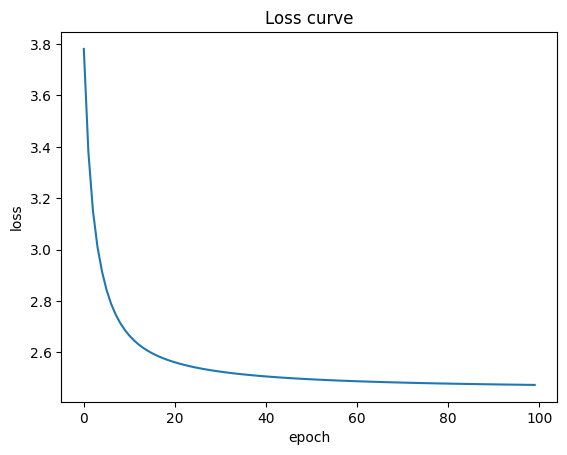

In [108]:
plt.plot(range(100), loss_log)
plt.title("Loss curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [120]:
# sampling from the trained network

for i in range(10):
    idx = 0
    while True:
        xtest_one_hot = torch.nn.functional.one_hot(torch.tensor([idx]), num_classes=27).float()
        logits = xtest_one_hot @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
        output_idx = torch.multinomial(probs, num_samples=1, replacement=True)
        print(itos[output_idx], end="")
        idx = output_idx
        if output_idx == 0:
            break
    print("")

jaram.
lysadzahanalylhande.
zquyninn.
mrl.
charime.
evinalia.
femaybr.
rda.
kon.
a.


The predicted names are not of great quality because of the simplicity of the neural network used. It only consists of a single layer made up of 27 neurons. We will iterate on the neural nets in upcoming works.

#### Additional points:-

1. You can add a regularization loss to the total loss value during training to force the model to take up weights closer to zero. This is equivalent to smoothing of probabilities in the statistical approach

    `loss += 0.01 * (W**2).mean() # squaring the weights and averaging`

2. Doing dot product with one hot input vector is equivalent to plucking out the probability distribution for that input character. This is the same as picking the probability distribution of the input character and sampling from it.